In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Loading training and Validation arrays

In [2]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [3]:
npzfile = np.load(r'C:\Users\drish\Desktop\projects all\DrishtantMusicGenreClassification\fma_metadata\shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394, 8)


In [4]:
npzfile = np.load(r'C:\Users\drish\Desktop\projects all\DrishtantMusicGenreClassification\fma_metadata\shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800, 8)


Checking by plotting a spectogram

Experimental


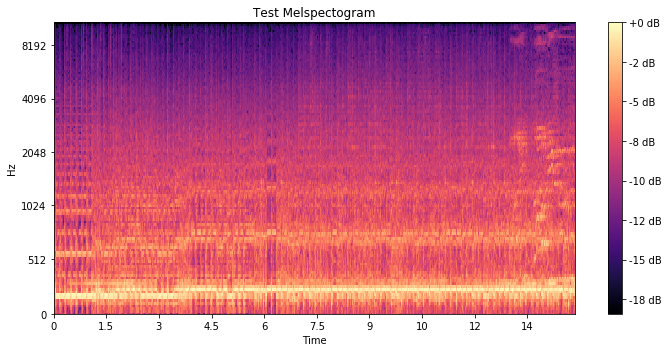

In [5]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

Parallel CNN RNN Model

In [6]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [7]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 50
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
#     flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
#     opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [8]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 640
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [12]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
#     plt.plot(history.history['acc'])
#     plt.plot(history.history['val_acc'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 640, 128, 1) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 638, 128, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 319, 64, 16)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 317, 64, 32)  1568        max_pooling2d[0][0]              
____________________________________________________________________________

Epoch 10/50
100/100 [==============================] - 274s 3s/step - loss: 1.4490 - accuracy: 0.4811 - val_loss: 1.5029 - val_accuracy: 0.4400 - lr: 5.0000e-04
Epoch 11/50
100/100 [==============================] - 275s 3s/step - loss: 1.4431 - accuracy: 0.4834 - val_loss: 1.5124 - val_accuracy: 0.4525 - lr: 5.0000e-04
Epoch 12/50
100/100 [==============================] - 274s 3s/step - loss: 1.4176 - accuracy: 0.4997 - val_loss: 1.5326 - val_accuracy: 0.4212 - lr: 5.0000e-04
Epoch 13/50
100/100 [==============================] - 272s 3s/step - loss: 1.4003 - accuracy: 0.5063 - val_loss: 1.5171 - val_accuracy: 0.4675 - lr: 5.0000e-04
Epoch 14/50
100/100 [==============================] - 262s 3s/step - loss: 1.3840 - accuracy: 0.5081 - val_loss: 1.4962 - val_accuracy: 0.4650 - lr: 5.0000e-04
Epoch 15/50
100/100 [==============================] - 196s 2s/step - loss: 1.3699 - accuracy: 0.5127 - val_loss: 1.6150 - val_accuracy: 0.4087 - lr: 5.0000e-04
Epoch 16/50
100/100 [=============

100/100 [==============================] - 230s 2s/step - loss: 1.2029 - accuracy: 0.5830 - val_loss: 1.5627 - val_accuracy: 0.4475 - lr: 5.0000e-04
Epoch 28/50
100/100 [==============================] - 204s 2s/step - loss: 1.1824 - accuracy: 0.5876 - val_loss: 1.4820 - val_accuracy: 0.5038 - lr: 5.0000e-04
Epoch 29/50
100/100 [==============================] - 204s 2s/step - loss: 1.1659 - accuracy: 0.6006 - val_loss: 1.4647 - val_accuracy: 0.5075 - lr: 5.0000e-04
Epoch 30/50
100/100 [==============================] - 203s 2s/step - loss: 1.1578 - accuracy: 0.5956 - val_loss: 1.5234 - val_accuracy: 0.4875 - lr: 5.0000e-04
Epoch 31/50
100/100 [==============================] - 275s 3s/step - loss: 1.1426 - accuracy: 0.6110 - val_loss: 1.4841 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 32/50
100/100 [==============================] - 276s 3s/step - loss: 1.1225 - accuracy: 0.6106 - val_loss: 1.4502 - val_accuracy: 0.4800 - lr: 5.0000e-04
Epoch 33/50
100/100 [=========================

100/100 [==============================] - 303s 3s/step - loss: 0.9329 - accuracy: 0.6817 - val_loss: 1.5984 - val_accuracy: 0.4812 - lr: 5.0000e-04
Epoch 45/50
100/100 [==============================] - 301s 3s/step - loss: 0.9245 - accuracy: 0.6783 - val_loss: 1.7167 - val_accuracy: 0.4750 - lr: 5.0000e-04
Epoch 46/50
100/100 [==============================] - 262s 3s/step - loss: 0.9079 - accuracy: 0.6847 - val_loss: 1.5516 - val_accuracy: 0.4938 - lr: 5.0000e-04
Epoch 47/50
100/100 [==============================] - 233s 2s/step - loss: 0.8870 - accuracy: 0.6933 - val_loss: 1.6135 - val_accuracy: 0.4850 - lr: 5.0000e-04
Epoch 48/50
100/100 [==============================] - 232s 2s/step - loss: 0.8753 - accuracy: 0.6947 - val_loss: 1.5790 - val_accuracy: 0.5038 - lr: 5.0000e-04
Epoch 49/50
100/100 [==============================] - 190s 2s/step - loss: 0.8582 - accuracy: 0.7086 - val_loss: 1.6916 - val_accuracy: 0.4812 - lr: 5.0000e-04
Epoch 50/50
100/100 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


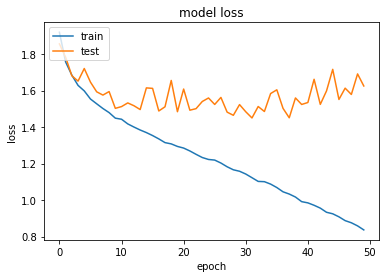

In [13]:
show_summary_stats(history)

In [14]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.38      0.67      0.48       100
 Experimental       0.40      0.40      0.40       100
         Folk       0.57      0.77      0.66       100
      Hip-Hop       0.59      0.46      0.52       100
 Instrumental       0.49      0.38      0.43       100
International       0.65      0.52      0.58       100
          Pop       0.19      0.11      0.14       100
         Rock       0.67      0.64      0.66       100

     accuracy                           0.49       800
    macro avg       0.49      0.49      0.48       800
 weighted avg       0.49      0.49      0.48       800



In [15]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.49375


Test Set

In [17]:
npzfile = np.load(r'C:\Users\drish\Desktop\projects all\DrishtantMusicGenreClassification\fma_metadata\test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [18]:
from keras.models import load_model

weights_path = 'models/parallel/weights.best.h5'
model = load_model(weights_path)

In [19]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [20]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000000000000016 0.004623813018385694


In [21]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.59      0.51      0.55       100
 Experimental       0.30      0.30      0.30       100
         Folk       0.24      0.28      0.26       100
      Hip-Hop       0.63      0.80      0.70       100
 Instrumental       0.43      0.41      0.42       100
International       0.58      0.45      0.51       100
          Pop       0.26      0.19      0.22       100
         Rock       0.49      0.61      0.54       100

     accuracy                           0.44       800
    macro avg       0.44      0.44      0.44       800
 weighted avg       0.44      0.44      0.44       800



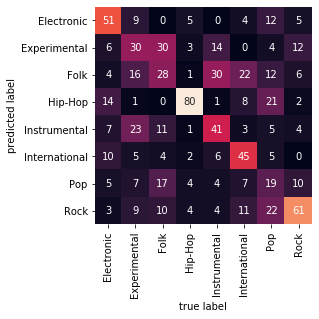

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [23]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.44375
